<a href="https://colab.research.google.com/github/KMkhim/PredictStock/blob/main/predict_KBANK_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.Data Collection

In [ ]:
pip install settrade-v2

In [8]:
import settrade_v2

In [9]:
from settrade_v2 import Investor

investor = Investor(
                  app_id="ctHtdubCgTYEUsVW",
                  app_secret="AOoIpKESVRd1Dk0mwNoutsmWTMBt+0+DXePc5wD3kdqV",
                  broker_id="SANDBOX",
                  app_code="SANDBOX",
                  is_auto_queue = False)

INFO:settradev2:[Elapsed time 1.173554s]login - success


## (1.1) นำเข้าข้อมูล จาก settrade

โดยใช้ API

In [10]:
market = investor.MarketData()

In [11]:
res = market.get_candlestick(
          symbol="KBANK",
          interval="1d",
          start= "2021-01-01T00:00:00",
          end="2024-12-23T23:59:00",
          normalized=True,
)

INFO:settradev2:[Elapsed time 1.346534s]get_candlestick - success


In [12]:
df = pd.DataFrame(res)

In [13]:
df

,lastSequence,time,open,high,low,close,volume,value
0,0,1640278800,138.5,138.5,137.5,138.0,3486527,4.814381e+08
1,0,1640538000,138.5,139.0,137.5,138.0,5986995,8.277282e+08
2,0,1640624400,138.5,141.5,138.5,141.0,17648900,2.470986e+09
3,0,1640710800,141.0,142.5,140.5,142.0,20394674,2.884583e+09
4,0,1640797200,142.5,142.5,140.5,142.0,14045829,1.988265e+09
...,...,...,...,...,...,...,...,...
723,0,1734368400,157.0,157.5,153.5,153.5,7105405,1.102022e+09
724,0,1734454800,155.0,155.0,153.5,154.5,6806338,1.049204e+09
725,0,1734541200,153.0,154.0,152.5,154.0,9571090,1.465307e+09
726,0,1734627600,153.0,153.0,151.5,152.5,8416287,1.280899e+09


# 2.Data Preparation

## (2.1) เปลี่ยนเลข timestamp

In [17]:
import datetime

In [18]:
# Extract the list of timestamps
timestamps = res['time']

# Iterate over the timestamps and convert them to datetime objects
date_times = [datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d') for timestamp in timestamps]
df['date'] = date_times

In [19]:
df.head()

,lastSequence,time,open,high,low,close,volume,value,date
0,0,1640278800,138.5,138.5,137.5,138.0,3486527,4.814381e+08,2021-12-23
1,0,1640538000,138.5,139.0,137.5,138.0,5986995,8.277282e+08,2021-12-26
2,0,1640624400,138.5,141.5,138.5,141.0,17648900,2.470986e+09,2021-12-27
3,0,1640710800,141.0,142.5,140.5,142.0,20394674,2.884583e+09,2021-12-28
4,0,1640797200,142.5,142.5,140.5,142.0,14045829,1.988265e+09,2021-12-29


## (2.2) เอาคอลัม date มาเป็น index

In [20]:
df.set_index('date', inplace=True)
df.head()

,lastSequence,time,open,high,low,close,volume,value
date,,,,,,,,
2021-12-23,0,1640278800,138.5,138.5,137.5,138.0,3486527,4.814381e+08
2021-12-26,0,1640538000,138.5,139.0,137.5,138.0,5986995,8.277282e+08
2021-12-27,0,1640624400,138.5,141.5,138.5,141.0,17648900,2.470986e+09
2021-12-28,0,1640710800,141.0,142.5,140.5,142.0,20394674,2.884583e+09
2021-12-29,0,1640797200,142.5,142.5,140.5,142.0,14045829,1.988265e+09


## (2.3) check missing value

In [21]:
df.isnull().sum()

,0
lastSequence,0
time,0
open,0
high,0
low,0
close,0
volume,0
value,0


## (2.4) เลือก column and row  to train

เลือก column ราคาปิด

In [22]:
df = df.close

In [23]:
df.head()

,close
date,
2021-12-23,138.0
2021-12-26,138.0
2021-12-27,141.0
2021-12-28,142.0
2021-12-29,142.0


แบ่งข้อมูลเป็นสองชุด

ชุด train คือข้อมูลตั้งแต่ 2021-12-23 ถึง 2023-12-31

ชุด test คือข้อมูลตั้งแต่ 2024-01-01 ถึง 2024-12-22

In [28]:
# แบ่งข้อมูลออกเป็น 2 ช่วงเวลา
df_2023 = df.loc[:'2023-12-31']  # ข้อมูลสิ้นปี 2023
df_2024 = df.loc['2024-01-01':]  # ข้อมูลตั้งแต่ต้นปี 2024

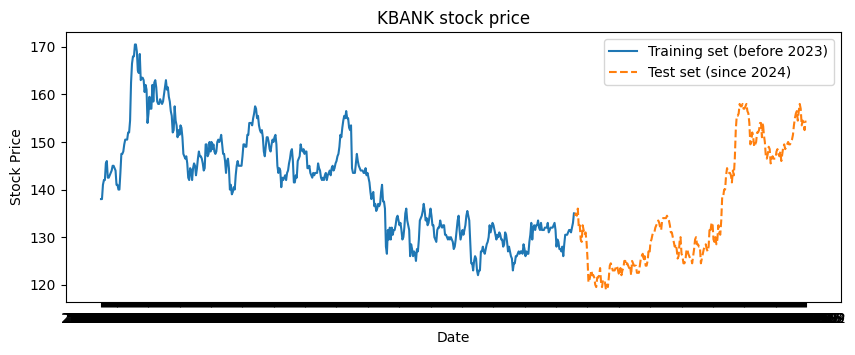

In [35]:
# Plot ข้อมูล
plt.figure(figsize=(10, 3.5))
plt.plot(df_2023, label='Training set (before 2023)')
plt.plot(df_2024, label='Test set (since 2024)', linestyle='--')  # เส้นปะเพื่อแยกกลุ่ม

# ตั้งค่ากราฟ
plt.legend()
plt.title('KBANK stock price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [36]:
print('Samples:', len(df))
print('Training set size:', len(df_2023))
print('Test set size:', len(df_2024))

Samples: 728
Training set size: 489
Test set size: 239


## (2.5) Normalize ค่าให้อยู่ในช่วง 0 ถึง 1

In [38]:
from sklearn.preprocessing import MinMaxScaler

data = df.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaler = scaler.fit_transform(data)

In [40]:
data_scaler[:5]

array([[0.36893204],
       [0.36893204],
       [0.42718447],
       [0.44660194],
       [0.44660194]])

## (2.6) เปลี่ยนข้อมูลให้เป็นเมทริกซ์

In [43]:
def covertToMatrix(data, step=1):
  X, Y = [], []
  for i in range(len(data)-step):
    d = i + step
    X.append(data[i:d, :])
    Y.append(data[d, :])
  return np.array(X), np.array(Y)

##  (2.7) Train-Test Split

In [158]:
n_train = 489

train, test = data_scaler[:n_train], data_scaler[n_train:]
train.shape, test.shape

((489, 1), (239, 1))

กำหนดค่า step ให้ย้อนหลัง 60 วัน

In [159]:
step = 65

X_train, y_train = covertToMatrix(train, step)
X_test, y_test = covertToMatrix(test, step)

print("X train, Test (after conversion):" , X_train.shape, X_test.shape)
print("y train, Test (after conversion):" , y_train.shape, y_test.shape)

X train, Test (after conversion): (424, 65, 1) (174, 65, 1)
y train, Test (after conversion): (424, 1) (174, 1)


# 3.Model Building

GRU 2 ชั้น

Dropout 20%

Activation : RELU

Output 1 Node



In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

In [161]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(step, 1), activation='relu'))
model.add(Dropout(0.2))
model.add(GRU(units=40 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_26 (GRU)                         │ (None, 65, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 65, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_27 (GRU)                         │ (None, 40)                  │          11,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,031 (74.34 KB)

 Trainable params: 19,031 (74.34 KB)

 Non-trainable params: 0 (0.00 B)

# 4.Training

In [167]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0048
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0050
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0044
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0037
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0046
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0043
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0038
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0041
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0043
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0035
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0044
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0047
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0042
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0042
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0037
Epoc

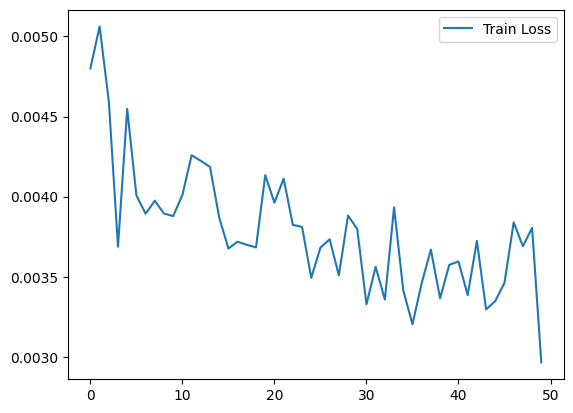

In [168]:
plt.plot(history.history['loss'] , label='Train Loss')
plt.legend()
plt.show()

# 5.Evaluation

In [169]:
testPredict = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [170]:
from sklearn.metrics import mean_squared_error,r2_score

testPredict_inv = scaler.inverse_transform(testPredict)
y_test_inv = scaler.inverse_transform(y_test)

r2_test = r2_score(y_test_inv, testPredict_inv)
rmse_test = np.sqrt(mean_squared_error(y_test_inv, testPredict_inv))

print("R2 Score: {:.3f}". format(r2_test))
print("RMSE: {:.3f}". format(rmse_test))

R2 Score: 0.952
RMSE: 2.526


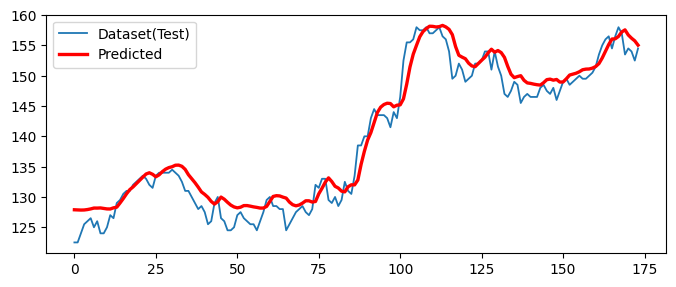

In [171]:
plt.figure(figsize=(12-4, 3.1))
plt.plot(y_test_inv,lw=1.3, label='Dataset(Test)')
plt.plot(testPredict_inv,'r',lw = 2.4, label='Predicted')
plt.legend()
plt.show()